In [19]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
routes = pd.read_csv('gtfs/routes.csv')
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type
0,0_A1,5,A1,NaN,WKD MILANÓWEK GRUDÓW - WKD/ - Opacz-Kolonia/ -...,2
1,0_A12,5,A12,NaN,WARSZAWA ŚRÓDMIEŚCIE WKD - Opacz-Kolonia/ - WK...,2
2,0_E-1,2,E-1,NaN,METRO STADION NARODOWY - Sokola - Zwycięzców -...,3
3,0_E-2,2,E-2,NaN,METRO RATUSZ ARSENAŁ - al. „Solidarności” - pl...,3
4,0_L-1,2,L-1,NaN,PIASECZNO PKP PIASECZNO - Piaseczno/Towarowa -...,3


In [29]:
# based on my great experience with warsaw public transport i can determine myself which route types are which
print(routes['route_type'].unique())
routes_sample = routes.groupby("route_type", group_keys=False).apply(
    lambda g: g.sample(1, random_state=12)
)
routes_sample

[2 3 0]


C:\Users\alicj\AppData\Local\Temp\ipykernel_16760\4059406245.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  routes_sample = routes.groupby("route_type", group_keys=False).apply(


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type
2100,6_18,2,18,NaN,ŻERAŃ FSO - Jagiellońska - Starzyńskiego - mos...,0
1726,5_R6,5,R6,NaN,WARSZAWA ZACHODNIA - Zielonka/ - Kobyłka/Ossow...,2
2131,6_125,2,125,NaN,MIĘDZYLESIE - al. Dzieci Polskich - Żegańska -...,3


In [30]:
# 18 is tram, R6 is railway and 125 is bus so:
# 0 - tram
# 2 - railway
# 3 - bus

In [31]:
def clustering_coefficient(G):
    C = {}
    for u in G.nodes():
        neighbors = list(G.neighbors(u))
        k = len(neighbors)
        if k < 2:
            C[u] = 0.0
            continue

        triangles = 0
        for i in range(k):
            for j in range(i + 1, k):
                a = neighbors[i]
                b = neighbors[j]
                # check if neighbors are connected
                if G.has_edge(a, b):
                    triangles += 1

        # possible edges among neighbors
        possible = k * (k - 1) / 2
        C[u] = triangles / possible
    return C

def average_clustering_coefficient(G):
    C = clustering_coefficient(G)
    return sum(C.values()) / len(C)

In [32]:
def degree_distribution(G):
    degrees = [d for n, d in G.degree()]
    hist, bin_edges = np.histogram(degrees, bins=range(max(degrees) + 2))
    return hist, bin_edges

In [41]:
def edge_weight_distribution(G):
    weights = [data['weight'] for u, v, data in G.edges(data=True)]
    hist, bin_edges = np.histogram(weights, bins=10)
    return hist, bin_edges

In [33]:
def calculate_basic_characteristics(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = [deg for node, deg in G.degree()]
    avg_degree = sum(degrees) / len(degrees) if degrees else 0
    max_degree = max(degrees) if degrees else 0
    average_clustering = average_clustering_coefficient(G)
    std_degree = np.std(degrees) if degrees else 0
    avg_edge_weight = np.mean([data['weight'] for u, v, data in G.edges(data=True)]) if G.number_of_edges() > 0 else 0
    max_edge_weight = np.max([data['weight'] for u, v, data in G.edges(data=True)]) if G.number_of_edges() > 0 else 0
    std_edge_weight = np.std([data['weight'] for u, v, data in G.edges(data=True)]) if G.number_of_edges() > 0 else 0

    characteristics = {
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Average Degree": avg_degree,
        "Standard Deviation of Degree": float(std_degree),
        "Max Degree": max_degree,
        "Average Clustering Coefficient": average_clustering,
        "Average Edge Weight": avg_edge_weight,
        "Max Edge Weight": max_edge_weight,
        "Standard Deviation of Edge Weight": float(std_edge_weight)
    }
    return characteristics

In [34]:
G_full = nx.read_graphml("networkx_graphs/full_network.graphml")
G_tram = nx.read_graphml("networkx_graphs/tram_layer.graphml")
G_railway = nx.read_graphml("networkx_graphs/rail_layer.graphml")
G_bus = nx.read_graphml("networkx_graphs/bus_layer.graphml")

In [35]:
results = pd.DataFrame([
    calculate_basic_characteristics(G_full),
    calculate_basic_characteristics(G_tram),
    calculate_basic_characteristics(G_railway),
    calculate_basic_characteristics(G_bus)
], index=["Full Network", "Tram Network", "Railway Network", "Bus Network"]
)

In [36]:
results

,Number of Nodes,Number of Edges,Average Degree,Standard Deviation of Degree,Max Degree,Average Clustering Coefficient,Average Edge Weight,Max Edge Weight,Standard Deviation of Edge Weight
Full Network,6767,8954,2.646372,1.101524,13,0.007888,2.251619,18,1.837371
Tram Network,619,762,2.462036,0.856278,7,0.000000,3.326772,13,2.215323
Railway Network,62,126,4.064516,1.242668,10,0.000000,1.690476,4,0.849503
Bus Network,6099,8066,2.645024,1.105849,13,0.008752,2.158815,18,1.774812


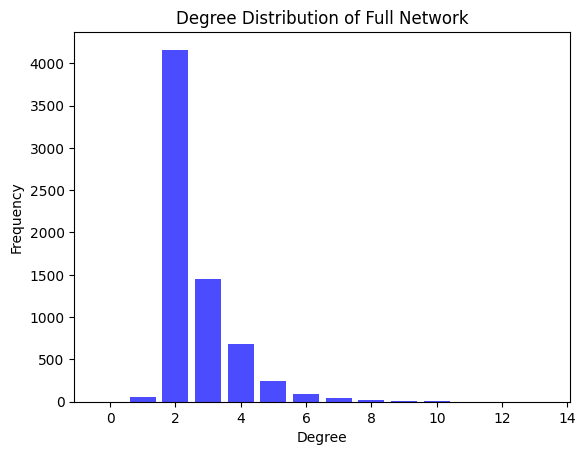

In [37]:
degree_hist, degree_bins = degree_distribution(G_full)
plt.bar(degree_bins[:-1], degree_hist, width=0.8, color='b', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Full Network')
plt.show()

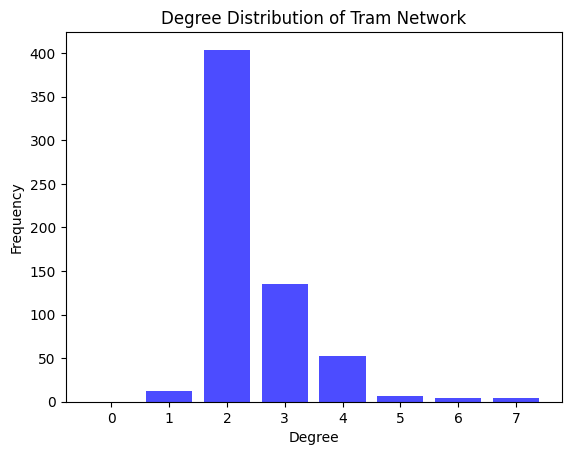

In [38]:
degree_hist, degree_bins = degree_distribution(G_tram)
plt.bar(degree_bins[:-1], degree_hist, width=0.8, color='b', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Tram Network')
plt.show()

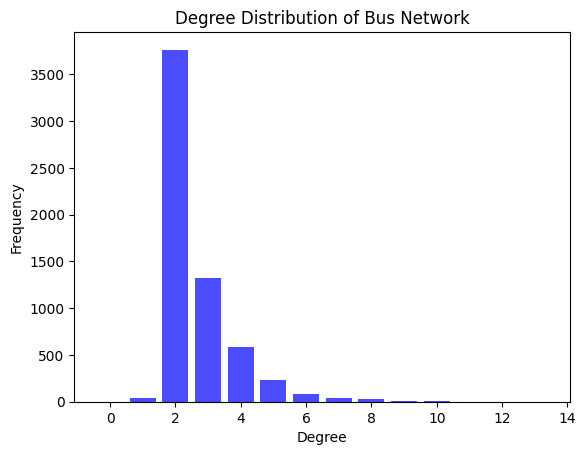

In [39]:
degree_hist, degree_bins = degree_distribution(G_bus)
plt.bar(degree_bins[:-1], degree_hist, width=0.8, color='b', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Bus Network')
plt.show()

Text(0.5, 1.0, 'Degree Distribution of Railway Network')

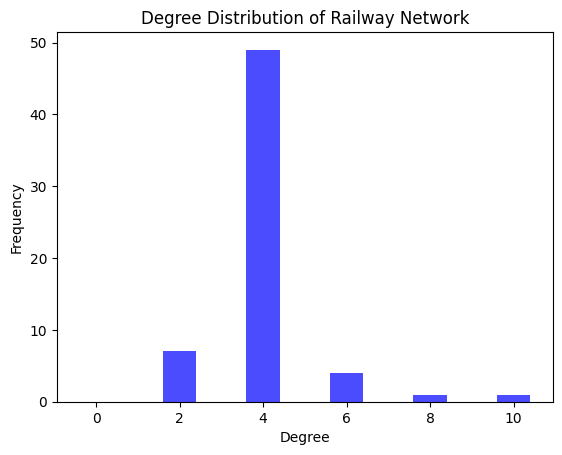

In [40]:
degree_hist, degree_bins = degree_distribution(G_railway)
plt.bar(degree_bins[:-1], degree_hist, width=0.8, color='b', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Railway Network')

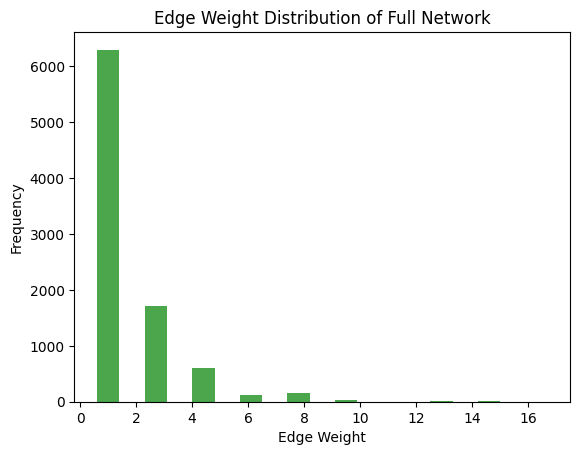

In [42]:
edge_hist, edge_bins = edge_weight_distribution(G_full)
plt.bar(edge_bins[:-1], edge_hist, width=0.8, color='g', alpha=0.7)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution of Full Network')
plt.show()

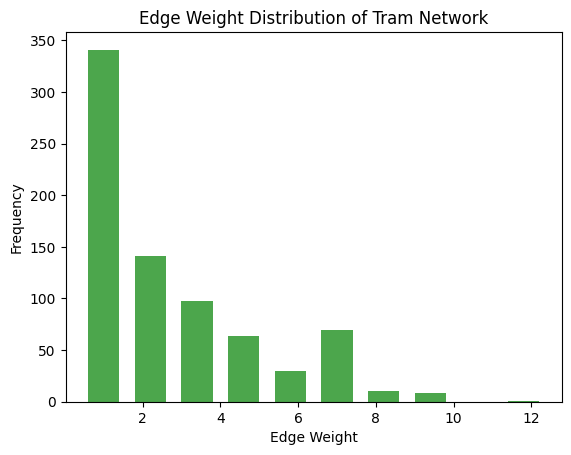

In [43]:
edge_hist, edge_bins = edge_weight_distribution(G_tram)
plt.bar(edge_bins[:-1], edge_hist, width=0.8, color='g', alpha=0.7)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution of Tram Network')
plt.show()

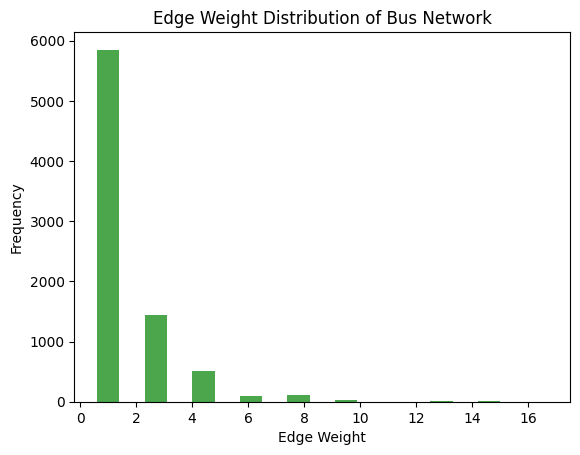

In [44]:
edge_hist, edge_bins = edge_weight_distribution(G_bus)
plt.bar(edge_bins[:-1], edge_hist, width=0.8, color='g', alpha=0.7)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution of Bus Network')
plt.show()


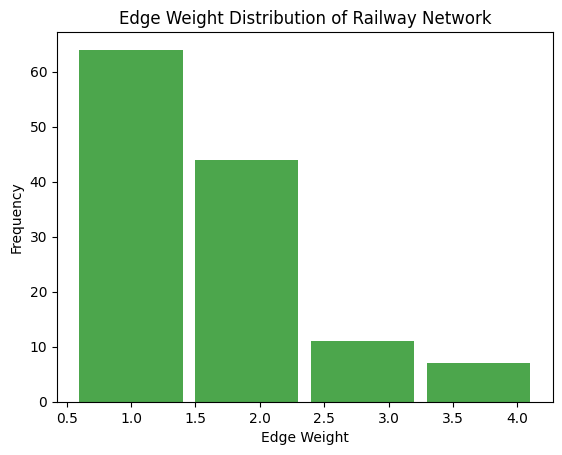

In [45]:
edge_hist, edge_bins = edge_weight_distribution(G_railway)
plt.bar(edge_bins[:-1], edge_hist, width=0.8, color='g', alpha=0.7)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution of Railway Network')
plt.show()